<a href="https://colab.research.google.com/github/nesanders/mywra_precipitation_2022/blob/main/2022_05_24_MyRWA_29yr_Precipitation_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Purpose

This notebook contains an analysis of 29 years of Mystic River watershed (MA) precipitation data compiled by the MystiC River Watershed Association.

# Imports

In [153]:
import io

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from googleapiclient.http import MediaIoBaseDownload


# Definitions

In [154]:
DATA_FILE_URL = 'https://docs.google.com/spreadsheets/d/11SwiR7bbEyAH90Nw_yASIOPfEadsTY4-/edit?usp=sharing&ouid=101677718735234570704&rtpof=true&sd=true'

In [155]:
def read_excel_from_google_drive(url: str, **kwargs) -> pd.DataFrame:
    """If given a Google drive share link for an Excel file, construct a file 
    URL and pass it to pd.read_excel
    """
    file_url = 'https://drive.google.com/uc?id=' + url.split('/')[-2]
    return pd.read_excel(file_url, **kwargs)

In [156]:
def extract_storm_events(
  rain_data: pd.Series, 
  threshold: float=1e-3, 
  window: int=4
) -> pd.DataFrame:
    """Use a simple windowing algorithm to identify storm events.
    
    This works by scanning across the timeseries data using a rolling average.  
    If the rolling average over a window `window` drops below `threshold, the 
    storm event is considered to have ended.

    Parameters
    ----------
    rain_data: pd.Series
        Input DataFrame of precipitation timeseries
    threshold: float=0
        Severity threshold; average rainfall above this value is considered a 
        storm
    window: int=4
        A contiguous storm event is defined by having a rolling average over 
        this window size yielding an average precipitation > `threshold`.
    
    Returns
    -------
    pd.DataFrame
        Has the following columns:
        index : sequential integer ID of the storm
        'total_precip' : integrated rainfall value of that storm
        'start_time', 'end_time' : stat and end timestamps of the storm
    """
    event_mask = (
        rain_data.rolling(window=window).mean() > threshold).astype(int)
    event_mask_edges = event_mask[1:] - event_mask[:-1].values
    event_counter = (event_mask_edges == 1).cumsum()
    n_events = max(event_counter)
    out_dict = {
        'start_time': event_mask_edges.index[event_mask_edges == 1],
        'end_time': event_mask_edges.index[event_mask_edges == -1],
        'total_precip': [rain_data.where(event_counter == n).sum() 
                        for n in range(n_events)]
    }
    # The first element will be a non-storm, so we trim it from the output
    return pd.DataFrame(out_dict).iloc[1:]
  

# Get data
Follows the example here https://stackoverflow.com/a/56611995

In [157]:
# Load data
# NOTE: This can take a minute or so to run
data_df = read_excel_from_google_drive(DATA_FILE_URL)

In [159]:
# Minor formatting tweaks
data_df.rename(columns={'Date/Time': 'time'}, inplace=True)
data_df.set_index('time', inplace=True)

In [165]:
LOCATIONS = data_df.columns.tolist()
print(LOCATIONS)

['BO-DI-2 (in)', 'CH-BO-1 (in)']


In [166]:
# Ensure sorting
data_df.sort_index(inplace=True)

# Ensure consistent sampling
template_spacing = (data_df.index[1] - data_df.index[0]).seconds
np.testing.assert_allclose(
    (data_df.index[1:] - data_df.index[:-1]).seconds, 
    np.ones(len(data_df) - 1) * template_spacing,
    err_msg="Spacing of data_df timestamps is not uniform",
    atol=1)

In [167]:
# Run storm finding algorithm
# NOTE this is slow - it takes >15 minutes!
storm_dfs = {}
for col in LOCATIONS:
    print(f'Extracting storms from {col}')
    storm_dfs[col] = extract_storm_events(data_df.loc[:, col])

Extracting storms from BO-DI-2 (in)
Extracting storms from CH-BO-1 (in)


### Exploratory data examples

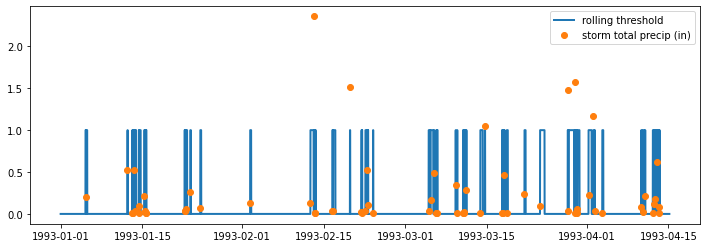

In [168]:
# Plot a few months of rolling thresholded data
x = (data_df.rolling(4).mean() > 1e-3).astype(float)[:10000]
plt.figure(figsize=(12, 4))
plt.plot(x.index, x.values[:, 0], lw=2, marker=None, label='rolling threshold')
col_a = list(storm_dfs.keys())[0]
sel = storm_dfs[col_a]['start_time'] < x.index.max()
plt.plot(storm_dfs[col_a].loc[sel, 'start_time'], 
         storm_dfs[col_a].loc[sel, 'total_precip'], 
         marker='o', label='storm total precip (in)', lw=0)
plt.legend()

Text(0, 0.5, 'Storm edges')

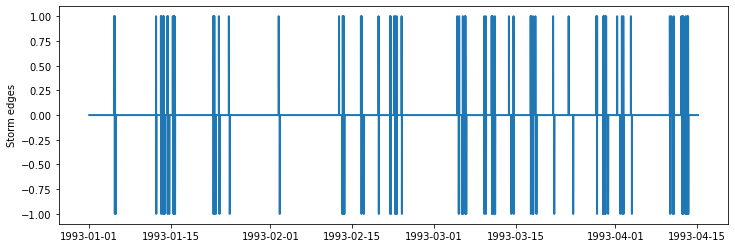

In [169]:
# Plot a few months of rolling threshold edge data
x = (data_df.rolling(4).mean() > 1e-3).astype(float)[:10000]
plt.figure(figsize=(12, 4))
plt.plot(x.index[:-1], x.values[1:, 0] - x.values[:-1, 0], lw=2, marker=None)
plt.ylabel('Storm edges')

In [170]:
storm_dfs

{'BO-DI-2 (in)':                   start_time                end_time  total_precip
 1    1993-01-05 09:45:00.000 1993-01-05 13:15:00.000          0.20
 2    1993-01-12 10:30:00.000 1993-01-12 11:30:00.000          0.52
 3    1993-01-13 06:30:00.000 1993-01-13 07:30:00.000          0.01
 4    1993-01-13 08:00:00.000 1993-01-13 15:00:00.000          0.01
 5    1993-01-13 15:15:00.000 1993-01-13 18:00:00.000          0.53
 ...                      ...                     ...           ...
 6728 2021-12-25 08:29:59.787 2021-12-25 15:59:59.787          0.07
 6729 2021-12-26 00:44:59.787 2021-12-26 05:44:59.787          0.33
 6730 2021-12-28 05:14:59.787 2021-12-28 06:14:59.787          0.19
 6731 2021-12-30 11:44:59.787 2021-12-30 14:29:59.787          0.01
 6732 2021-12-30 15:14:59.787 2021-12-30 17:44:59.787          0.04
 
 [6732 rows x 3 columns],
 'CH-BO-1 (in)':                   start_time                end_time  total_precip
 1    1993-01-12 10:15:00.000 1993-01-12 11:15:00.000   

# Plots

## 1. Storm events per year
Make a line plot of total storm events per year

In [171]:
storm_df_samp = pd.DataFrame({
    col: df.set_index('start_time').resample('Y')['total_precip'].agg(len) 
    for col, df in storm_dfs.items()
})

Text(0.5, 0, 'Year')

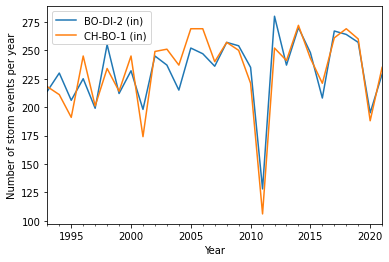

In [172]:
storm_df_samp.plot()
plt.ylabel('Number of storm events per year')
plt.xlabel('Year')

## 2. Average storm severity
Make a line plot of average storm severity (in inches) per year

In [173]:
storm_df_samp_precip = pd.DataFrame({
    col: df.set_index('start_time').resample('Y')['total_precip'].mean()
    for col, df in storm_dfs.items()
})

Text(0.5, 0, 'Year')

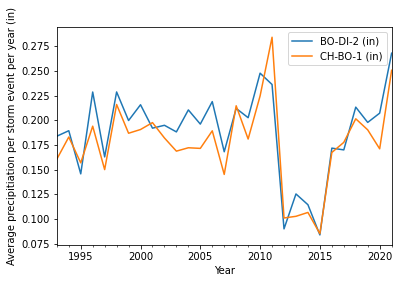

In [174]:
storm_df_samp_precip.plot()
plt.ylabel('Average precipitiation per storm event per year (in)')
plt.xlabel('Year')

## 3. Extreme storm severity

Make a line plot of 90th percentile storm severity (in inches) per year


In [175]:
QUANTILE = 0.9
storm_df_samp_quantile = pd.DataFrame({
    col: df.set_index('start_time').resample('Y')['total_precip']\
        .quantile(QUANTILE)
    for col, df in storm_dfs.items()
})

Text(0.5, 0, 'Year')

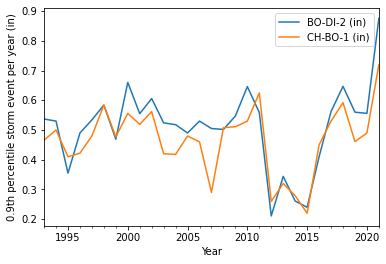

In [176]:
storm_df_samp_quantile.plot()
plt.ylabel(f'{QUANTILE}th percentile storm event per year (in)')
plt.xlabel('Year')

## 4. Monthly storm frequency evolution

Make a lineplot of # storm events per month, which different lines for each 5 yr period

In [188]:
storm_df_samp_monthly = pd.DataFrame({
    col: df.set_index('start_time').resample('M')['total_precip'].apply(len)
    for col, df in storm_dfs.items()
})
storm_df_samp_monthly.reset_index(inplace=True)
storm_df_samp_monthly['month'] = storm_df_samp_monthly['start_time']\
    .apply(lambda x: x.month)

In [189]:
storm_df_samp_monthly.set_index('start_time', inplace=True)
print(storm_df_samp_monthly)
storm_df_samp_monthly_samp = storm_df_samp_monthly.resample('10Y')

            BO-DI-2 (in)  CH-BO-1 (in)  month
start_time                                   
1993-01-31            17            10      1
1993-02-28            14            16      2
1993-03-31            25            25      3
1993-04-30            23            24      4
1993-05-31            13            16      5
...                  ...           ...    ...
2021-08-31            19            18      8
2021-09-30            21            16      9
2021-10-31            23            25     10
2021-11-30            12            15     11
2021-12-31            20            21     12

[348 rows x 3 columns]


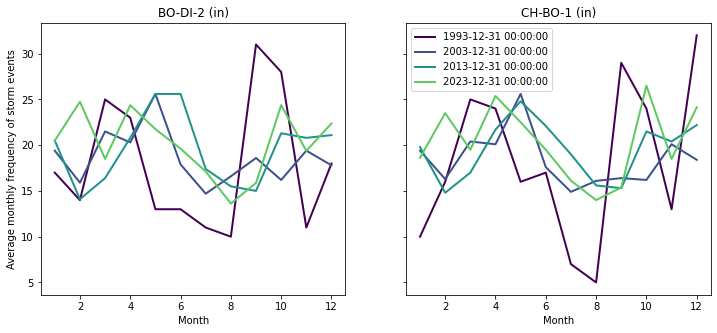

In [190]:
fig, axs = plt.subplots(1, len(LOCATIONS), figsize=(12,5), 
                        sharex='all', sharey='all')
for group_i, (group, group_df) in enumerate(storm_df_samp_monthly_samp):
    for ax_i, location in enumerate(LOCATIONS):
        gdf = group_df.groupby('month').mean()
        color = plt.cm.viridis(group_i / len(storm_df_samp_monthly_samp))
        axs[ax_i].plot(gdf.index, gdf[location], label=group, color=color, lw=2)

for i, ax in enumerate(axs):
    ax.set_title(LOCATIONS[i])
    ax.set_xlabel('Month')

axs[0].set_ylabel('Average monthly frequency of storm events')

plt.legend()

## 5. Monthly storm severity evolution


Make a lineplot of average storm severity (in inches) per month, which different lines for each 5 yr period


In [191]:
storm_df_samp_monthly_precip = pd.DataFrame({
    col: df.set_index('start_time').resample('M')['total_precip'].sum()
    for col, df in storm_dfs.items()
})
storm_df_samp_monthly_precip.reset_index(inplace=True)
storm_df_samp_monthly_precip['month'] = \
    storm_df_samp_monthly_precip['start_time'].apply(lambda x: x.month)

In [192]:
storm_df_samp_monthly_precip.set_index('start_time', inplace=True)
print(storm_df_samp_monthly)
storm_df_samp_monthly_precip_samp = storm_df_samp_monthly_precip.resample('10Y')

            BO-DI-2 (in)  CH-BO-1 (in)  month
start_time                                   
1993-01-31            17            10      1
1993-02-28            14            16      2
1993-03-31            25            25      3
1993-04-30            23            24      4
1993-05-31            13            16      5
...                  ...           ...    ...
2021-08-31            19            18      8
2021-09-30            21            16      9
2021-10-31            23            25     10
2021-11-30            12            15     11
2021-12-31            20            21     12

[348 rows x 3 columns]


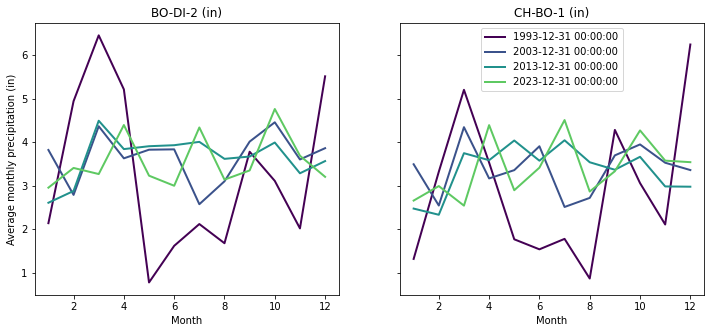

In [193]:
fig, axs = plt.subplots(1, len(LOCATIONS), figsize=(12,5), 
                        sharex='all', sharey='all')
for group_i, (group, group_df) in enumerate(storm_df_samp_monthly_precip_samp):
    for ax_i, location in enumerate(LOCATIONS):
        gdf = group_df.groupby('month').mean()
        color = plt.cm.viridis(group_i / len(storm_df_samp_monthly_precip_samp))
        axs[ax_i].plot(gdf.index, gdf[location], label=group, color=color, lw=2)

for i, ax in enumerate(axs):
    ax.set_title(LOCATIONS[i])
    ax.set_xlabel('Month')

axs[0].set_ylabel('Average monthly precipitation (in)')

plt.legend()

## 6. Distribution of severity

Make a cumulative distribution function of storm severity, with a different line for each 5 yr period